# Bagging

Vamos a utilizar el siguiente dataset: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

Las siguientes celdas lo descargan e importan:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1X0MT5YFVOduVogJ9cZKjCJ7fs-OdVuAT' -O weather.csv

In [3]:
df = pd.read_csv('weatherAUS.csv')

In [4]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


Vamos a descartar las columnas:

- Sunshine          
- Evaporation       
- Cloud3pm          
- Cloud9am  
- Location
- Date       
- WindGustDir
- WindDir9am 

In [5]:
to_drop = ['Sunshine','Evaporation','Cloud3pm','Cloud9am','Location','Date', 'WindGustDir', 'WindDir9am']
df = df.drop(columns=to_drop)
df.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,13.4,22.9,0.6,44.0,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No
1,7.4,25.1,0.0,44.0,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No
2,12.9,25.7,0.0,46.0,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No
3,9.2,28.0,0.0,24.0,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No
4,17.5,32.3,1.0,41.0,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No


In [6]:
df.shape

(145460, 15)

Descartar todas las filas que tengan nulos:

In [7]:
df = df.dropna()

In [8]:
df.shape

(119016, 15)

Separamos en X e y. Nuestro objetivo es predecir si va a llover mañana.

In [9]:
X = df.copy().drop("RainTomorrow", axis=1)
y = df.RainTomorrow.copy()

Aplicamos train test split. El set de test tendrá un 20% de los datos con un random state de 42 y stratify.

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Aplicar one hot encoder a las variables categóricas.

Recuerden hacer fit en train y luego en test solo transform.

In [12]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False).fit(X_train[["WindDir3pm", "RainToday"]])

# Train

encoded = ohe.transform(X_train[["WindDir3pm", "RainToday"]])
encoded_df = pd.DataFrame(columns=ohe.get_feature_names_out(), data= encoded, index=X_train.index)

X_train = pd.concat([X_train, encoded_df],  axis='columns')

# Test

encoded_test = ohe.transform(X_test[["WindDir3pm", "RainToday"]])
encoded_test_df = pd.DataFrame(columns=ohe.get_feature_names_out(), data= encoded_test, index=X_test.index)

X_test = pd.concat([X_test, encoded_test_df],  axis='columns')



Dropear las columnas originales:

In [13]:
X_train = X_train.drop(["WindDir3pm", "RainToday"], axis=1)
X_test = X_test.drop(["WindDir3pm", "RainToday"], axis=1)

Llevar el target a una variable numérica:

- 1 si va a llover mañana
- 0 si no va a llover mañana

In [14]:
y_train = y_train.map({'Yes':1,'No':0})
y_test = y_test.map({'Yes':1,'No':0})

Entrenar un arbol de decision con:
- max_depth=10
- random_state=0

y obtener el classification report para train y test.

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,auc,roc_curve

clf = DecisionTreeClassifier(max_depth=10, random_state=0).fit(X_train, y_train)
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, test_pred)
aucroc=auc(fpr, tpr)


print(classification_report(y_train, train_pred))
print(classification_report(y_test, test_pred))
print(f'Área ROC de test= {aucroc}')

              precision    recall  f1-score   support

           0       0.89      0.96      0.92     74409
           1       0.79      0.56      0.65     20803

    accuracy                           0.87     95212
   macro avg       0.84      0.76      0.79     95212
weighted avg       0.86      0.87      0.86     95212

              precision    recall  f1-score   support

           0       0.87      0.94      0.90     18603
           1       0.70      0.49      0.58      5201

    accuracy                           0.84     23804
   macro avg       0.78      0.72      0.74     23804
weighted avg       0.83      0.84      0.83     23804

Área ROC de test= 0.7169683160947541


In [103]:
from sklearn.metrics import ConfusionMatrixDisplay,accuracy_score,confusion_matrix
def fmatcon2(yt,yp,model,title='Title',label_celd=1,size=(7,5),colormap='Pastel2',num_celd=20,text_celd=10,num_celd_col='black',text_celd_col='DarkSlateGray'):
    if label_celd==0:
        lb=0
        label_celd=[['Verdadero Negativo', 'Falso Positivo'],['Falso Negativo', 'Verdadero Positivo']]
    if label_celd==1:
        lb=1
        label_celd=[[f'{t}-{p}'for p in model.classes_] for t in model.classes_]
    cm=confusion_matrix(yt, yp)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
    disp.plot(cmap=colormap)
    disp.ax_.set_title(title,fontsize=20)
    fig = disp.figure_
    fig.set_figwidth(size[0])
    fig.set_figheight(size[1]) 
    # fig.suptitle('Plot of confusion matrix')
    
    # Cambiar tamaño de letra del contenido de la matriz
    for text in disp.ax_.texts:
        text.set_fontsize(num_celd)  # Establece el tamaño de letra a 12 puntos
        text.set_color(num_celd_col)
    for i in range(len(model.classes_)):
        for j in range(len(model.classes_)):
            disp.ax_.text(j, i-0.3, f'{label_celd[i][j]}',ha="center", va='top',color=text_celd_col, fontsize=text_celd)
        
    plt.show()
    if lb != 1:
        print(classification_report(yt,yp))
        fpr=cm[0,1]/(cm[0, 1]+cm[0,0])
        tpr=cm[1,1]/(cm[1,1]+cm[1,0])
        return fpr,tpr
    return None

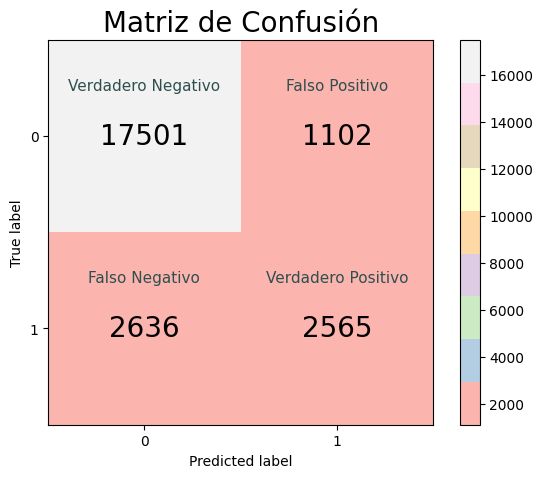

              precision    recall  f1-score   support

           0       0.87      0.94      0.90     18603
           1       0.70      0.49      0.58      5201

    accuracy                           0.84     23804
   macro avg       0.78      0.72      0.74     23804
weighted avg       0.83      0.84      0.83     23804



(0.0592377573509649, 0.493174389540473)

In [17]:
from f_func import fmatcon
from sklearn.metrics import ConfusionMatrixDisplay
# help(ConfusionMatrixDisplay)
fmatcon(y_test, test_pred,clf,'Matriz de Confusión',label_celd=0,colormap='Pastel1',text_celd=11)
# len(y_test[y_test==0])

Ahora, usar un Bagging Classifier armado con árboles de decisión: 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

Los árboles que usemos en este clasificador, deberán tener la misma profundidad máxima (max_depth) que el árbol que entrenamos recién.

Además usar: 

- n_estimators = 200
- n_jobs = -1 -> ¿Qué pasa si sacamos esto?
- random_state = 0 -> En el arbol y en el BaggingClassifier

In [17]:
from sklearn.ensemble import BaggingClassifier

clf = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=10, random_state=0), n_estimators = 200, n_jobs = -1, random_state=0)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, test_pred)
aucroc=auc(fpr, tpr)


print(classification_report(y_train, train_pred))
print(classification_report(y_test, test_pred))
print(f'Área ROC de test= {aucroc}')

KeyboardInterrupt: 

Ahora, probar con un RandomForestClassifier. 

Los hiperparámetros serán igual que los anteriores:

- max_depth=10
- n_estimators=200
- n_jobs=-1
- random_state=0

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=10, n_estimators = 200, n_jobs = -1, random_state=0)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, test_pred)
aucroc=auc(fpr, tpr)

print(classification_report(y_train, train_pred))
print(classification_report(y_test, test_pred))
print(f'Área ROC de test= {aucroc}')

Ahora, en el random forest, imprimir la importancia de las features:

In [ ]:
clf.feature_importances_

In [ ]:
fi = pd.DataFrame(columns=["FEATURE", "IMPORTANCE"])
fi["FEATURE"] = X_train.columns
fi["IMPORTANCE"] = clf.feature_importances_
fi = fi.sort_values("IMPORTANCE", ascending=False)

In [ ]:
plt.figure(figsize=(5, 15))
colors = sns.color_palette("viridis", n_colors=len(fi))
sns.barplot(y=fi.FEATURE, x=fi.IMPORTANCE, hue=fi.IMPORTANCE, palette=colors)
plt.show()

Ahora, aplicar random forest en su proyecto del primer sprint.

Buscar los mejores hiperparámetros con grid search y finalmente imprimir el feature importance de las variables que utilizaron para entrenar.

# Boosting

Ahora, vamos a trabajar sobre los mismos datos que ya pre-procesamos pero vamos a entrenar modelos de boosting.

Arrancamos por Adaboost.

### Adaboost 
Aplica secuencialmente modelos simples, uno tras de otro. En cada paso de un modelo a otro se aumentan los pesos de los elementos mal clasificados, para que el siguiente modelo de más importancia a los elementos mal clasificados. Para establecer estos pesos en teoría utiliza las siguiente fórmulas (comienza con todos los pesos iguales):
$$w_i' = w_i \cdot e^{-\alpha \cdot \beta \cdot y_i \hat{y}_i}$$
en donde:  
  
$w_i$ es el peso actual del elemento $i$.   
$w_i'$ es el peso del elemento para el siguiente modelo.   
$e=$ 2.71828...  
$y_i$ es la etiqueta verdadera.  
$\hat{y}_i$ es la etiqueta predicha por el modelo anterior.    
$\beta$ es un coeficiente que controla la velocidad a la que el algoritmo AdaBoost aprende de los clasificadores débiles. (learning_rate) 
  
y $\alpha$ es:  
$$\alpha = \ln\left(\frac{1 - \text{tasa de error ponderada}}{\text{tasa de error ponderada}}\right)$$
$$\alpha = \ln\left(\frac{\text{suma de pesos de elementos bien clasificados}}{\text{suma de pesos de elementos mal clasificados}}\right)$$

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

En general, en Adaboost se utilizan como estimadores "débiles", árboles de decision con max_depth = 1.

Vamos a entrenar Adaboost utilizando:

- n_estimators = 200
- random_state = 0

Y evaluarlo. Imprimir el classification_report de train y de test.

Medir el tiempo que demora en entrenar Adaboost con %%time

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
#COMPLETAR
ada_m=AdaBoostClassifier(n_estimators=200, learning_rate=1.0, random_state=0).fit(X_train,y_train)

In [ ]:
y_train_pred = ada_m.predict(X_train)
y_test_pred = ada_m.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, test_pred)
aucroc=auc(fpr, tpr)

print(classification_report(y_train, train_pred))
print(classification_report(y_test, test_pred))
print(f'Área ROC de test= {aucroc}')

Imprimir feature importances de adaboost y graficar

In [ ]:
#COMPLETAR
from f_func import fimpovar
fi = fimpovar(X_train, ada_m) 

### XGBOOST

Ahora probaremos XGBOOST: [https://xgboost.readthedocs.io/en/latest/python/index.html](https://xgboost.readthedocs.io/en/latest/python/index.html).

En google colab, xgboost ya está instalado por lo que no es necesario instalarlo. Si utilizan otro entorno, probablemente tengan que instalarlo con pip.

In [ ]:
from xgboost import XGBClassifier

Entrenar el classifier y generar las predicciones junto al classification report.

Podemos explorar sus hiperparámetros en: https://xgboost.readthedocs.io/en/latest/parameter.html

Utilizar como **n_estimators=200.**

Midan el tiempo con %%time y lo comparemos con Adaboost

In [ ]:
#COMPLETAR
# Crear el clasificador y entrenar xgboost
xgb_m = XGBClassifier(n_estimators=200).fit(X_train,y_train)

In [ ]:
y_train_pred = xgb_m.predict(X_train)
y_test_pred = xgb_m.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, test_pred)
aucroc=auc(fpr, tpr)

print(classification_report(y_train, train_pred))
print(classification_report(y_test, test_pred))
print(f'Área ROC de test= {aucroc}')

En xgboost también podemos acceder a feature_importances. Graficar:

In [ ]:
#COMPLETAR
fi = fimpovar(X_train, xgb_m) 

### LIGHT GBM

Otra librería que implementa un modelo de boosting muy eficiente es LightGBM: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

Vamos a probarla en nuestro conjunto de datos.

Entrenar, medir métricas y graficar feature importance.

Recuerden medir el tiempo que tarda en entrenar para comparar con los anteriores.

Vamos a utilizar 200 como n_estimators nuevamente, para comparar los resultados de todos los modelos.

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
#COMPLETAR
lgbm_m=LGBMClassifier(n_estimators=200,verbosity=-1).fit(X_train,y_train)

In [ ]:
y_train_pred = lgbm_m.predict(X_train)
y_test_pred = lgbm_m.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, test_pred)
aucroc=auc(fpr, tpr)

print(classification_report(y_train, train_pred))
print(classification_report(y_test, test_pred))
print(f'Área ROC de test= {aucroc}')

### Stacking

Finalmente, armaremos un stacking de modelos utilizando sklearn.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html

En este caso, los estimadores los tenemos que pasar en el parámetro "estimators" y el final estimator, en "final_estimator".

Utilizaremos los estimadores:

- random forest: RandomForestClassifier(max_depth=10, n_estimators = 200, n_jobs = -1, random_state=0)

- xgbooost: XGBClassifier(n_estimators=200)

- Ligth gbm: LGBMClassifier(n_estimators=200)

y como final estimator un DecisionTreeClassifier(max_depth=5)

Armar el modelo de stacking:


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier

clf1 = RandomForestClassifier(max_depth=10, n_estimators=200, n_jobs=-1, random_state=0)
clf2 = XGBClassifier(n_estimators=200, random_state=0)
clf3 = LGBMClassifier(n_estimators=200, random_state=0,verbosity=-1)
fclf=DecisionTreeClassifier(max_depth=5, random_state=0)

estimators = [('rf',clf1),('xgbc',clf2),('lgbm',clf3)]

# Crear el clasificador de stacking
stack_clf = StackingClassifier(
    estimators,
    final_estimator=fclf
)

# Entrenar el clasificador de stacking
stack_clf.fit(X_train, y_train)

Entrenarlo e imprimir classification report (recuerden medir el tiempo).

Va a tardar unos minutos.

In [ ]:
#COMPLETAR
y_train_pred = xgb_m.predict(X_train)
y_test_pred = xgb_m.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, test_pred)
aucroc=auc(fpr, tpr)

print(classification_report(y_train, train_pred))
print(classification_report(y_test, test_pred))
print(f'Área ROC de test= {aucroc}')